# Header: Install & Import Dependencies

In [ ]:
!nvidia-smi

Mon Apr  7 18:43:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} GB of available RAM")

Your runtime has 13.6 GB of available RAM


In [ ]:
from google.colab import drive
#drive.mount("/content/drive")
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install transformers datasets sentencepiece ftfy --quiet

In [ ]:
# Usual Libraries
import pandas as pd
import json
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# Transformers
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)

# Datasets
from datasets import Dataset

# Weird Unicode Cleaning
from ftfy import fix_text

In [ ]:
import torch
torch.cuda.empty_cache() # Clear GPU cache

# Load Fixed Test Set

In [ ]:
def with_prompt(review_text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + review_text.strip()
    )

# Apply prompt to each review
test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/Test_set.csv")
test_gold_df["Prompted Review"] = test_gold_df["Raw Review"].astype(str).str.strip().apply(with_prompt)
test_reviews_prompted = test_gold_df["Prompted Review"].tolist()

In [ ]:
inputs_gold = tokenizer(test_reviews_prompted, return_tensors="pt", padding=True, truncation=True).to(model_v2.device)


# Rerun v0 — Zero-Shot (No Prompt)

In [ ]:
# Import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration

# 1. Load gold test set from new folder structure
test_path = "/content/drive/MyDrive/acosqe/evaluation/Test_set.csv" # Note that this was small gold
test_gold_df = pd.read_csv(test_path)
test_reviews = test_gold_df["Raw Review"].str.strip().tolist()

# 2. Load base T5 model and tokenizer
model_v0 = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# 3. Run zero-shot inference (no prompt)
inputs_v0 = tokenizer(test_reviews, return_tensors="pt", padding=True, truncation=True).to(model_v0.device)
outputs_v0 = model_v0.generate(
    input_ids=inputs_v0["input_ids"],
    attention_mask=inputs_v0["attention_mask"],
    max_length=256
)
decoded_v0 = tokenizer.batch_decode(outputs_v0, skip_special_tokens=True)

# 4. Add predictions to DataFrame
test_gold_df["Prediction_v0_NoPrompt"] = decoded_v0

# 5. Save to structured evaluation folder
save_path = "/content/drive/MyDrive/acosqe/eval_outputs/predictions_v0.csv"
test_gold_df.to_csv(save_path, index=False)
print(f"Saved v0 predictions to {save_path}")


# Rerun v1 — Zero-Shot (With Prompt)

In [ ]:
# 1. Apply ACOSQE prompt to each review
def with_prompt(review):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + review.strip()
    )

prompted_reviews = [with_prompt(r) for r in test_reviews]

# 2. Run inference using same base T5 model
inputs_v1 = tokenizer(prompted_reviews, return_tensors="pt", padding=True, truncation=True).to(model_v0.device)
outputs_v1 = model_v0.generate(
    input_ids=inputs_v1["input_ids"],
    attention_mask=inputs_v1["attention_mask"],
    max_length=256
)
decoded_v1 = tokenizer.batch_decode(outputs_v1, skip_special_tokens=True)

# 3. Add predictions and save
test_gold_df["Prediction_v1_Prompted"] = decoded_v1
save_path_v1 = "/content/drive/MyDrive/acosqe/eval_outputs/predictions_v1.csv"
test_gold_df.to_csv(save_path_v1, index=False)
print(f"Saved v1 predictions to {save_path_v1}")



# Rerun v2 — Train on 248 Reviews with Fixed Preprocessing

1. Load your previous annotated file

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/Quad_Annotation_anonymised.csv", encoding="ISO-8859-1")
df = df[df["Done"].isin(["Y"])]
df = df[df["Aspect Term"].notnull() & (df["Aspect Term"].str.strip() != "")]
df["Review Text"] = df["Review Text"].str.strip()
print(f"DataFrame size after pre-processing: {df.size}")
# Remove gold test reviews to avoid leakage
test_set = set(test_reviews)
df = df[~df["Review Text"].isin(test_set)] # Better than subset
print(f"DataFrame size after removing gold test reviews: {df.size}")

DataFrame size after pre-processing: 3528
DataFrame size after removing gold test reviews: 3512


In [ ]:
# a. Fill missing reviews first (for multi-quad reviews)
df["Review Text"] = df["Review Text"].fillna(method="ffill")

# b. Clean and standardise all relevant text fields
for col in ["Review Text", "Aspect Term", "Opinion Term", "Aspect Category", "Sentiment Polarity"]:
    df[col] = df[col].astype(str).str.strip()

# c. Lowercase sentiment polarity (optional for categories if needed)
df["Sentiment Polarity"] = df["Sentiment Polarity"].str.lower()


<ipython-input-10-83c84e7253f0>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Review Text"] = df["Review Text"].fillna(method="ffill")


2. Group reviews into T5 format

In [ ]:
from collections import defaultdict
import json

def with_prompt(review_text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + review_text.strip()
    )

def group_for_t5(df):
    grouped = defaultdict(list)
    for _, row in df.iterrows():
        quad = f"{row['Aspect Term'].strip()}##{row['Aspect Category'].strip()}##{row['Opinion Term'].strip()}##{row['Sentiment Polarity'].strip().lower()}"
        grouped[row["Review Text"].strip()].append(quad)
    return [{"input": with_prompt(review), "output": " [SSEP] ".join(quads)} for review, quads in grouped.items()]

t5_examples = group_for_t5(df)

from sklearn.model_selection import train_test_split
train_ex, val_ex = train_test_split(t5_examples, test_size=0.2, random_state=42)


In [ ]:
import json

def save_jsonl(data, path):
    with open(path, "w", encoding="utf-8") as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
    print(f"Saved {len(data)} examples to {path}")

save_jsonl(train_ex, "/content/drive/MyDrive/acosqe/raw_data/train_acosqe_v2.2.jsonl")
save_jsonl(val_ex, "/content/drive/MyDrive/acosqe/raw_data/val_acosqe_v2.2.jsonl")

Saved 196 examples to /content/drive/MyDrive/acosqe/raw_data/train_acosqe_v2.2.jsonl
Saved 50 examples to /content/drive/MyDrive/acosqe/raw_data/val_acosqe_v2.2.jsonl


3. Preprocess with hard masking

In [ ]:
model_name = "t5-small"  # or any other T5 variant
tokenizer = T5Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def preprocess(example):
    inputs = tokenizer(
        example["input"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    targets = tokenizer(
        text_target=example["output"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    labels = [(t if t != tokenizer.pad_token_id else -100) for t in targets["input_ids"]]
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": labels}

train_ds = Dataset.from_list(train_ex).map(preprocess, remove_columns=["input", "output"])
val_ds = Dataset.from_list(val_ex).map(preprocess, remove_columns=["input", "output"])


Map:   0%|          | 0/196 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

4. Train the v2 model

In [ ]:
model_v2 = T5ForConditionalGeneration.from_pretrained("t5-small")

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/acosqe/outputs_t5_v2_fixed",
    evaluation_strategy="epoch",
    logging_steps=50,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-4,
    predict_with_generate=True,
    report_to="none"
)

trainer_v2 = Seq2SeqTrainer(
    model=model_v2,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model_v2)
)

trainer_v2.train()


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-c16345911ef0>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_v2 = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,1.829533
2,2.635300,1.344164
3,2.635300,1.158573
4,1.322100,1.085823
5,1.322100,1.069460


TrainOutput(global_step=125, training_loss=1.809524383544922, metrics={'train_runtime': 58.2612, 'train_samples_per_second': 16.821, 'train_steps_per_second': 2.146, 'total_flos': 132634965442560.0, 'train_loss': 1.809524383544922, 'epoch': 5.0})

5. Inference on gold test set with v2

In [ ]:
# Reload best checkpoint
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/acosqe/outputs_t5_v2_fixed/checkpoint-125").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Load test set with prompt
test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/Test_set.csv")
test_gold_df["Prompted Review"] = test_gold_df["Raw Review"].astype(str).str.strip().apply(with_prompt)
test_reviews_prompted = test_gold_df["Prompted Review"].tolist()

# Tokenise inputs
inputs = tokenizer(test_reviews_prompted, return_tensors="pt", padding=True, truncation=True).to(model.device)

# Generate predictions
outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=256)
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Save predictions
test_gold_df["Prediction_v2"] = decoded
test_gold_df.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/predictions_v2_fixed.csv", index=False)

# Train v3 on ~1000 Annotated Reviews

1. Install & Set Up

In [ ]:
#!pip install transformers datasets accelerate sentencepiece evaluate
#from google.colab import drive
#drive.mount('/content/drive')

2. Load and Clean Annotated Data

In [ ]:
# Load raw annotated file
pii_df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/Quad_Annotation_Semi_Supervised.csv", encoding="ISO-8859-1")

# Define focused anonymisation rules
anonymisation_patterns = [
    (r'\bNEST\b', '[Company X]'),
    (r'\bNest\b', '[Company X]'),
    (r'\bMEM\d+\b', '[CompanyReference]'),
    (r'\b\d{10,11}\b', '[PhoneNumber]'),
    (r'\+?\d{1,3}[-.\s]??\(?\d+\)?[-.\s]??\d+[-.\s]??\d+', '[PhoneNumber]'),
    (r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', '[Email]'),
    (r'[A-Z]{1,2}\d{1,2}[A-Z]?\s*\d[A-Z]{2}', '[Postcode]'),
    (r'\b(?:sort code|account number|iban|bic|swift)[\s:\-]*[\w\d]+', '[BankDetail]', re.IGNORECASE),
]

def anonymise_text(text):
    for pattern in anonymisation_patterns:
        if len(pattern) == 2:
            text = re.sub(pattern[0], pattern[1], text)
        else:
            text = re.sub(pattern[0], pattern[1], text, flags=pattern[2])
    return text

# Apply anonymisation immediately to Review Text
pii_df["Review Text"] = pii_df["Review Text"].astype(str).apply(anonymise_text)

# strip the one col
for col in ["Aspect Term"
#, "Opinion Term", "Aspect Category", "Sentiment Polarity"
            ]:
    pii_df[col] = pii_df[col].astype(str).str.strip()

# Rename to anonymised df and delete original
df = pii_df.copy()
del pii_df


In [ ]:
# Fill missing reviews and clean
df["Review Text"] = df["Review Text"].fillna(method="ffill")
for col in ["Review Text", "Aspect Term", "Opinion Term", "Aspect Category", "Sentiment Polarity"]:
    df[col] = df[col].astype(str).str.strip()

df["Sentiment Polarity"] = df["Sentiment Polarity"].str.lower()

# Keep only validated and auto-tagged rows
df = df[df["Done"].isin(["Y", "AUTO"])]

<ipython-input-18-1021c2105566>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Review Text"] = df["Review Text"].fillna(method="ffill")


3. Remove Gold Test Set to Prevent Leakage

In [ ]:
test_set_path = "/content/drive/MyDrive/acosqe/evaluation/Test_set.csv" # Small
test_gold_df = pd.read_csv(test_set_path)
gold_reviews = set(test_gold_df["Raw Review"].astype(str).str.strip())
df = df[~df["Review Text"].isin(gold_reviews)]

4. Convert to T5 Format with Prompt

In [ ]:
from collections import defaultdict

def with_prompt(review_text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + review_text.strip()
    )

def group_for_t5(df):
    grouped = defaultdict(list)
    for _, row in df.iterrows():
        quad = f"{row['Aspect Term']}##{row['Aspect Category']}##{row['Opinion Term']}##{row['Sentiment Polarity']}"
        grouped[row["Review Text"]].append(quad)
    return [{"input": with_prompt(review), "output": " [SSEP] ".join(quads)} for review, quads in grouped.items()]

t5_examples = group_for_t5(df)

5. Split into Train / Validation Sets

In [ ]:
from sklearn.model_selection import train_test_split
train_ex, val_ex = train_test_split(t5_examples, test_size=0.15, random_state=42)

In [ ]:
save_jsonl(train_ex, "/content/drive/MyDrive/acosqe/raw_data/train_acosqe_v3.2.jsonl")
save_jsonl(val_ex, "/content/drive/MyDrive/acosqe/raw_data/val_acosqe_v3.2.jsonl")

Saved 1219 examples to /content/drive/MyDrive/acosqe/raw_data/train_acosqe_v2_fixed.jsonl
Saved 216 examples to /content/drive/MyDrive/acosqe/raw_data/val_acosqe_v2_fixed.jsonl


6. Tokenise + Prepare Dataset

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def preprocess(example):
    model_inputs = tokenizer(example["input"], padding="max_length", truncation=True, max_length=512)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["output"], padding="max_length", truncation=True, max_length=256)
    model_inputs["labels"] = [(l if l != tokenizer.pad_token_id else -100) for l in labels["input_ids"]]
    return model_inputs

train_ds = Dataset.from_list(train_ex).map(preprocess, remove_columns=["input", "output"])
val_ds = Dataset.from_list(val_ex).map(preprocess, remove_columns=["input", "output"])

Map:   0%|          | 0/1217 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/215 [00:00<?, ? examples/s]

In [ ]:
def save_jsonl(data, path):
    with open(path, "w", encoding="utf-8") as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
    print(f"Saved {len(data)} examples to {path}")

# Save train/val files with prompt
save_jsonl(train_ex, "/content/drive/MyDrive/acosqe/raw_data/train_acosqe_v3_fixed.jsonl")
save_jsonl(val_ex, "/content/drive/MyDrive/acosqe/raw_data/val_acosqe_v3_fixed.jsonl")


In [ ]:
#train_ds[0]  # view the first row
#train_ds[:5]  # view first 5 rows


In [ ]:
len(train_ds)

In [ ]:
input_lengths = [sum(example['attention_mask']) for example in train_ds]
max(input_lengths), min(input_lengths), sum(input_lengths) / len(input_lengths)

7. Set Training Arguments

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/acosqe/outputs_v3",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=3e-4,
    predict_with_generate=True,
    save_total_limit=3,  # Keep only last 3 checkpoints
    load_best_model_at_end=True,  # Enables auto-selection of best model
    metric_for_best_model="eval_loss",  # What "best" means
    greater_is_better=False,  # Because lower eval_loss is better
    report_to="none",
    fp16=True,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


8. Train Model (T5-small)

In [ ]:
from transformers import T5ForConditionalGeneration, Seq2SeqTrainer, DataCollatorForSeq2Seq

model = T5ForConditionalGeneration.from_pretrained("t5-small")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer)
)

trainer.train()

<ipython-input-26-e0a8baab605e>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,1.787100,0.643691
2,0.712100,0.547428
3,0.609100,0.495635
4,0.505900,0.491393
5,0.480000,0.486887


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=765, training_loss=0.7630536646624796, metrics={'train_runtime': 235.4644, 'train_samples_per_second': 25.843, 'train_steps_per_second': 3.249, 'total_flos': 823554861957120.0, 'train_loss': 0.7630536646624796, 'epoch': 5.0})

9. Inference on gold test set with v3

In [ ]:
# Reload best checkpoint
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v3/checkpoint-765").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Load test set with prompt
test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/Test_set.csv")
test_gold_df["Prompted Review"] = test_gold_df["Raw Review"].astype(str).str.strip().apply(with_prompt)
test_reviews_prompted = test_gold_df["Prompted Review"].tolist()

# Tokenise inputs
inputs = tokenizer(test_reviews_prompted, return_tensors="pt", padding=True, truncation=True).to(model.device)

# Generate predictions
outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=256)
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Save predictions
test_gold_df["Prediction_v3.2"] = decoded
test_gold_df.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/predictions_v3.2.csv", index=False)

# Run of V4 with 2000 annotations

In [ ]:
! pip install ftfy

In [ ]:
! pip install datasets

In [ ]:
# ========== Step 0: Setup ==========

# Run Header first

In [ ]:
# ========== Step 1: Load and Anonymise Data ==========

df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/Quad_Annotation_v4.csv", encoding="ISO-8859-1")
df.rename(columns={df.columns[0]: "Review Text"}, inplace=True)

# Anonymise sensitive tokens
text_col = "Review Text"
anonymisation_patterns = [
    (r'\bNEST\b', '[Company X]'),
    (r'\bNest\b', '[Company X]'),
    (r'\bMEM\d+\b', '[CompanyReference]'),
    (r'\b\d{10,11}\b', '[PhoneNumber]'),
    (r'\+?\d{1,3}[-.\s]??\(?\d+\)?[-.\s]??\d+[-.\s]??\d+', '[PhoneNumber]'),
    (r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', '[Email]'),
    (r'[A-Z]{1,2}\d{1,2}[A-Z]?\s*\d[A-Z]{2}', '[Postcode]'),
    (r'\b(?:sort code|account number|iban|bic|swift)[\s:\-]*[\w\d]+', '[BankDetail]', re.IGNORECASE),
]
# Apply anonymisation
def anonymise_text(text):
    for pattern in anonymisation_patterns:
        if len(pattern) == 2:
            text = re.sub(pattern[0], pattern[1], text)
        elif len(pattern) == 3:
            text = re.sub(pattern[0], pattern[1], text, flags=pattern[2])
    return text

df[text_col] = df[text_col].astype(str).apply(anonymise_text)

# Fix corrupted byte sequences like Â
df["Review Text"] = df["Review Text"].astype(str).apply(fix_text)

# Optional: strip remaining garbage characters
garbled_chars_pattern = r"[¤¦§©ª«®°±²³µ¶·¸»¼½¾¿]"
df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(garbled_chars_pattern, "", x))

# Keep only validated reviews
df = df[df["Done"].isin(["Y", "AUTO"])]


In [ ]:
df.shape

(6658, 8)

In [ ]:
# ========== Step 2: Remove Gold Test Reviews ==========

test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/GOLD_TEST.csv")
gold_reviews = set(test_gold_df["Review Text"].astype(str).str.strip())
df = df[~df["Review Text"].isin(gold_reviews)]

In [ ]:
# ========== Step 3: Clean and Group into T5 Format ==========

df["Review Text"] = df["Review Text"].fillna(method="ffill")
for col in ["Review Text", "Aspect Term", "Opinion Term", "Aspect Category", "Sentiment Polarity"]:
    df[col] = df[col].astype(str).str.strip()
df["Sentiment Polarity"] = df["Sentiment Polarity"].str.lower()

def with_prompt(text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + text.strip()
    )
def group_for_t5(df):
    grouped = defaultdict(list)
    for _, row in df.iterrows():
        quad = f"{row['Aspect Term']}##{row['Aspect Category']}##{row['Opinion Term']}##{row['Sentiment Polarity']}"
        grouped[row["Review Text"]].append(quad)
    return [{"input": with_prompt(review), "output": " [SSEP] ".join(quads)} for review, quads in grouped.items()]
t5_examples = group_for_t5(df)

<ipython-input-6-01e0d572df13>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Review Text"] = df["Review Text"].fillna(method="ffill")


In [ ]:
# ========== Step 4: Split and Save Train/Val ==========

train_ex, val_ex = train_test_split(t5_examples, test_size=0.10, random_state=42)

def save_jsonl(data, path):
    with open(path, "w", encoding="utf-8") as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
save_jsonl(train_ex, "/content/drive/MyDrive/acosqe/raw_data/train_acosqe_v4.jsonl")
save_jsonl(val_ex, "/content/drive/MyDrive/acosqe/raw_data/val_acosqe_v4.jsonl")

In [ ]:
# ========== Step 5: Preprocess for T5 with Masking Fix ==========

tokenizer = T5Tokenizer.from_pretrained("t5-small")
def preprocess(example):
    model_inputs = tokenizer(example["input"], padding="max_length", truncation=True, max_length=512)
    labels = tokenizer(example["output"], padding="max_length", truncation=True, max_length=256)
    model_inputs["labels"] = [(tid if tid != tokenizer.pad_token_id else -100) for tid in labels["input_ids"]]
    return model_inputs
train_ds = Dataset.from_list(train_ex).map(preprocess, remove_columns=["input", "output"])
val_ds = Dataset.from_list(val_ex).map(preprocess, remove_columns=["input", "output"])

Map:   0%|          | 0/2359 [00:00<?, ? examples/s]

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

In [ ]:
# ========== Step 6: Define Training Arguments ==========

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/acosqe/outputs_v4",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=3e-4,
    predict_with_generate=True,
    save_total_limit=4,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# ========== Step 7: Train the Model ==========

model = T5ForConditionalGeneration.from_pretrained("t5-small")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer)
)
train_result = trainer.train()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<ipython-input-13-8e987e86550a>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.824600,0.538817
2,0.536600,0.457399
3,0.459100,0.435194
4,0.374100,0.414666
5,0.304200,0.415374
6,0.278600,0.417916
7,0.255200,0.426218
8,0.242000,0.433443
9,0.211200,0.430258
10,0.223300,0.429390


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [ ]:
# Save best model explicitly after training
trainer.save_model("/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4.fix")
tokenizer.save_pretrained("/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4.fix")

('/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4/tokenizer_config.json',
 '/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4/special_tokens_map.json',
 '/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4/spiece.model',
 '/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4/added_tokens.json')

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4")

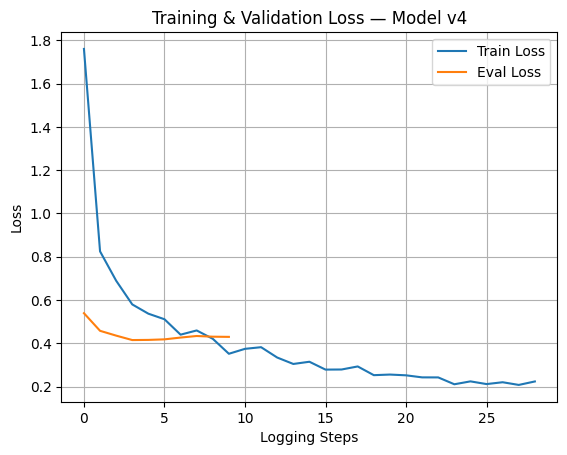

In [ ]:
# ========== Plot Loss Curves ==========

logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss — Model v4")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
 # ==========   Step 8: Test Model   ==========

In [ ]:
# Load val set used during training
val_path = "/content/drive/MyDrive/acosqe/raw_data/val_acosqe_v4.jsonl"
val_data = [json.loads(line) for line in open(val_path, "r")]

# Load trained model
model_path = "/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4"
model = T5ForConditionalGeneration.from_pretrained(model_path).to("cuda")
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Store results
error_rows = []

for entry in val_data:
    input_text = entry["input"]
    gold_output = entry["output"]

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    outputs = model.generate(**inputs, max_length=256)
    pred_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # String comparison
    if pred_output.strip() != gold_output.strip():
        error_rows.append({
            "Review": input_text.split("\n\n")[-1].strip(),
            "Prompted Input": input_text,
            "Gold Output": gold_output,
            "Predicted Output": pred_output
        })

# Save errors
df_errors = pd.DataFrame(error_rows)
df_errors.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/errors_val_v4.csv", index=False)
print(f"Saved {len(df_errors)} errors.")


Saved 338 errors.


In [ ]:
len(val_data)

411

In [ ]:
# Reload best model
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4")

# Load test set with prompt
test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/Test_set.csv")
test_gold_df["Prompted Review"] = test_gold_df["Raw Review"].astype(str).str.strip().apply(with_prompt)
test_reviews_prompted = test_gold_df["Prompted Review"].tolist()

# Tokenise inputs
inputs = tokenizer(test_reviews_prompted, return_tensors="pt", padding=True, truncation=True).to(model.device)

# Generate predictions
outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=256)
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Save predictions
test_gold_df["Prediction_v4"] = decoded
test_gold_df.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/predictions_v4.csv", index=False)

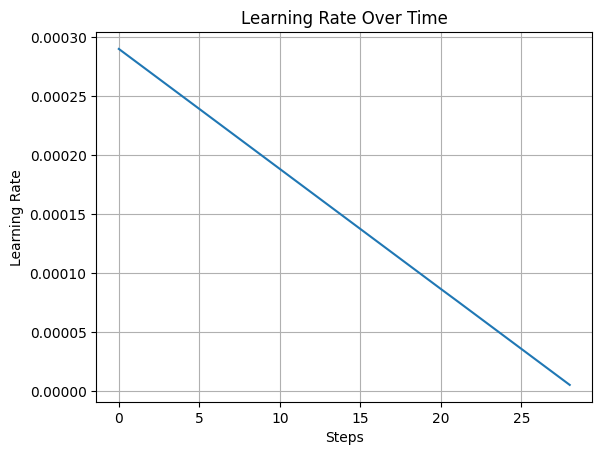

In [ ]:
# fig. Learning Rate Schedule
lr = [x["learning_rate"] for x in logs if "learning_rate" in x]
plt.plot(lr)
plt.title("Learning Rate Over Time")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

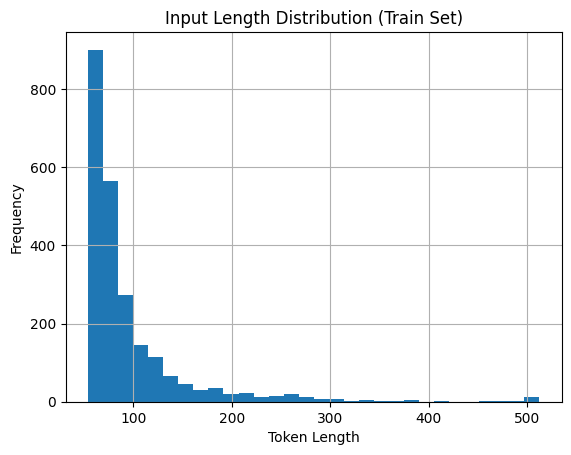

In [ ]:
# Fig. Token Length Distribution
input_lengths = [sum(x['attention_mask']) for x in train_ds]
plt.hist(input_lengths, bins=30)
plt.title("Input Length Distribution (Train Set)")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# Fig. Prediction Examples vs Gold Labels
# In results evaluation code

In [ ]:
# VALIDATION ERRORS

print(df_errors.columns)
print(df_errors.head())

Index(['Review', 'Prompted Input', 'Gold Output', 'Predicted Output'], dtype='object')
                                              Review  \
0  Anyone thinking of using [Company X] just plea...   
1  I have been in the [Company X] pension scheme ...   
2  Transferring my previous workplace pensions in...   
3  So difficult to use. Just went round and round...   
4  These are the actions of scammers and, as such...   

                                      Prompted Input  \
0  Extract all aspect-category-opinion-sentiment ...   
1  Extract all aspect-category-opinion-sentiment ...   
2  Extract all aspect-category-opinion-sentiment ...   
3  Extract all aspect-category-opinion-sentiment ...   
4  Extract all aspect-category-opinion-sentiment ...   

                                         Gold Output  \
0  withdraw my pension##Fund Management##hitting ...   
1  service##Customer Support##very pleased##posit...   
2  transferring pensions##Fund Management##easy##...   
3      use##Web

In [ ]:
def parse_acos_output(output):
    quads = []
    for quad in output.split("[SSEP]"):
        parts = [x.strip() for x in quad.strip().split("##")]
        if len(parts) == 4:
            quads.append({
                "Aspect": parts[0],
                "Category": parts[1],
                "Opinion": parts[2],
                "Sentiment": parts[3]
            })
    return quads


In [ ]:
error_rows = []

for i, row in df_errors.iterrows():
    gold_quads = parse_acos_output(row["Gold Output"])
    pred_quads = parse_acos_output(row["Predicted Output"])

    # Convert to set of tuples for easy matching
    gold_set = {tuple(d.values()) for d in gold_quads}
    pred_set = {tuple(d.values()) for d in pred_quads}

    # Identify types of mismatches
    missing = gold_set - pred_set
    extra = pred_set - gold_set
    matched = gold_set & pred_set

    for quad in missing:
        error_rows.append({
            "Review": row["Review"],
            "Error Type": "Missing Quad",
            "Aspect": quad[0],
            "Category": quad[1],
            "Opinion": quad[2],
            "Sentiment": quad[3]
        })
    for quad in extra:
        error_rows.append({
            "Review": row["Review"],
            "Error Type": "Hallucinated Quad",
            "Aspect": quad[0],
            "Category": quad[1],
            "Opinion": quad[2],
            "Sentiment": quad[3]
        })


In [ ]:
df_errors = pd.DataFrame(error_rows)


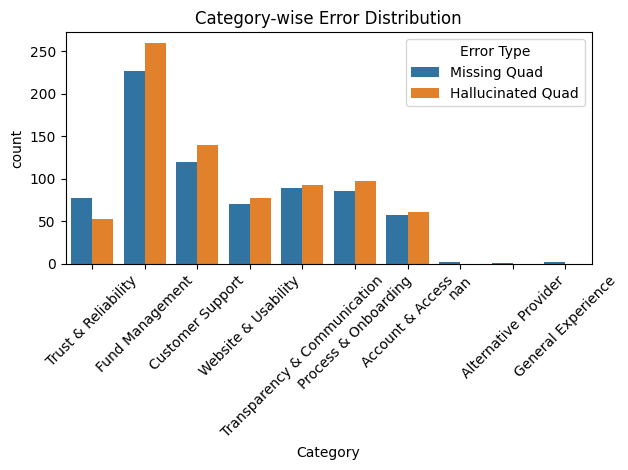

In [ ]:
# Fig. Category-wise Error Distribution
# import seaborn as sns

# 'errors' could be extracted from comparison logic e.g. missed or wrong category
sns.countplot(data=df_errors, x="Category", hue="Error Type")
plt.title("Category-wise Error Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Run V5

In [ ]:
# ========== Step 1: Load and Anonymise Data ==========

df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/Quad_Annotation_v5.csv", encoding="ISO-8859-1")
df.rename(columns={df.columns[0]: "Review Text"}, inplace=True)

# Anonymise sensitive tokens
text_col = "Review Text"
anonymisation_patterns = [
    (r'\bNEST\b', '[Company X]'),
    (r'\bNest\b', '[Company X]'),
    (r'\bMEM\d+\b', '[CompanyReference]'),
    (r'\b\d{10,11}\b', '[PhoneNumber]'),
    (r'\+?\d{1,3}[-.\s]??\(?\d+\)?[-.\s]??\d+[-.\s]??\d+', '[PhoneNumber]'),
    (r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', '[Email]'),
    (r'[A-Z]{1,2}\d{1,2}[A-Z]?\s*\d[A-Z]{2}', '[Postcode]'),
    (r'\b(?:sort code|account number|iban|bic|swift)[\s:\-]*[\w\d]+', '[BankDetail]', re.IGNORECASE),
]
# Apply anonymisation
def anonymise_text(text):
    for pattern in anonymisation_patterns:
        if len(pattern) == 2:
            text = re.sub(pattern[0], pattern[1], text)
        elif len(pattern) == 3:
            text = re.sub(pattern[0], pattern[1], text, flags=pattern[2])
    return text

df[text_col] = df[text_col].astype(str).apply(anonymise_text)

# Fix corrupted byte sequences like Â
df["Review Text"] = df["Review Text"].astype(str).apply(fix_text)

# Optional: strip remaining garbage characters
garbled_chars_pattern = r"[¤¦§©ª«®°±²³µ¶·¸»¼½¾¿]"
df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(garbled_chars_pattern, "", x))

# Keep only validated reviews
df = df[df["Done"].isin(["Y", "AUTO"])]
df.shape

(9328, 8)

In [ ]:
# ========== Step 2: Remove Gold Test Reviews ==========

test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/GOLD_TEST.csv") # Bigger test set to compute eval metrics
gold_reviews = set(test_gold_df["Review Text"].astype(str).str.strip())
df = df[~df["Review Text"].isin(gold_reviews)]

In [ ]:
# ========== Step 3: Clean and Group into T5 Format ==========

df["Review Text"] = df["Review Text"].fillna(method="ffill")
for col in ["Review Text", "Aspect Term", "Opinion Term", "Aspect Category", "Sentiment Polarity"]:
    df[col] = df[col].astype(str).str.strip()
df["Sentiment Polarity"] = df["Sentiment Polarity"].str.lower()

def with_prompt(text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + text.strip()
    )
def group_for_t5(df):
    grouped = defaultdict(list)
    for _, row in df.iterrows():
        quad = f"{row['Aspect Term']}##{row['Aspect Category']}##{row['Opinion Term']}##{row['Sentiment Polarity']}"
        grouped[row["Review Text"]].append(quad)
    return [{"input": with_prompt(review), "output": " [SSEP] ".join(quads)} for review, quads in grouped.items()]
t5_examples = group_for_t5(df)

In [ ]:
# ========== Step 4: Split and Save Train/Val ==========

train_ex, val_ex = train_test_split(t5_examples, test_size=0.15, random_state=42)

def save_jsonl(data, path):
    with open(path, "w", encoding="utf-8") as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
# save_jsonl(train_ex, "/content/drive/MyDrive/acosqe/raw_data/train_acosqe_v5.jsonl") # storage !!!!!!!
save_jsonl(val_ex, "/content/drive/MyDrive/acosqe/raw_data/val_acosqe_v5.jsonl")

In [ ]:
# ========== Step 5: Preprocess for T5 with Masking Fix ==========

tokenizer = T5Tokenizer.from_pretrained("t5-small")  # or "flan-t5-small" or "t5-base"
def preprocess(example):
    model_inputs = tokenizer(example["input"], padding="max_length", truncation=True, max_length=512)
    labels = tokenizer(example["output"], padding="max_length", truncation=True, max_length=256)
    model_inputs["labels"] = [(tid if tid != tokenizer.pad_token_id else -100) for tid in labels["input_ids"]]
    return model_inputs
train_ds = Dataset.from_list(train_ex).map(preprocess, remove_columns=["input", "output"])
val_ds = Dataset.from_list(val_ex).map(preprocess, remove_columns=["input", "output"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/532 [00:00<?, ? examples/s]

In [ ]:
# ========== Step 6: Define Training Arguments ==========

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/acosqe/outputs_v5", ## change for next version
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=3e-4,
    predict_with_generate=True,
    save_total_limit=4,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# ========== Step 7: Train the Model ==========

model = T5ForConditionalGeneration.from_pretrained("t5-small")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
train_result = trainer.train()

<ipython-input-19-20d77fcb6337>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.717700,0.485687
2,0.508600,0.429643
3,0.423600,0.406172
4,0.361600,0.399141
5,0.322400,0.398364
6,0.264000,0.401691
7,0.254300,0.403837


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [ ]:
# Save best model explicitly after training
trainer.save_model("/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5")
tokenizer.save_pretrained("/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5")

('/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5/tokenizer_config.json',
 '/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5/special_tokens_map.json',
 '/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5/spiece.model',
 '/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5/added_tokens.json')

In [ ]:
!ls -lh /content/drive/MyDrive/acosqe/evaluation/

total 164K
-rw------- 1 root root  519 Apr 11 22:19 category_confusion_matrix_v5.csv
-rw------- 1 root root 158K Apr 10 22:48 GOLD_TEST.csv
-rw------- 1 root root  182 Apr 10 22:50 GOLD_TEST.gsheet
-rw------- 1 root root 4.5K Mar 30 19:14 Test_set.csv
-rw------- 1 root root  182 Apr  9 20:46 Test_set.gsheet


In [ ]:
 # ==========   Step 8: Test Model   ==========

 # Reload best model
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5")

# Load test set with prompt
test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/Test_set.csv") # check new gold implementation in evaluation script
def with_prompt(text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + text.strip()
    )

test_gold_df["Prompted Review"] = test_gold_df["Raw Review"].astype(str).str.strip().apply(with_prompt)
test_reviews_prompted = test_gold_df["Prompted Review"].tolist()

# Tokenise inputs
inputs = tokenizer(test_reviews_prompted, return_tensors="pt", padding=True, truncation=True).to(model.device)

# Generate predictions
outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=256)
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Save predictions
test_gold_df["Prediction_v5"] = decoded
#test_gold_df.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/predictions_v5.csv", index=False)

Implementation Plan: Attention Heatmaps for v5:
- Load the trained v5 model and tokenizer.
- Tokenize a prompted input review.
- Run a forward pass using output_attentions=True.
- Visualise attention weights using heatmaps — usually from decoder cross-attention (decoder attending to encoder input tokens).

In [ ]:
# ========== Step 9: Attention Heatmaps (Gold Test Set) ==========
# Load model + tokenizer
model_path = "/content/drive/MyDrive/acosqe/outputs_v5/best_model_v5"
model = T5ForConditionalGeneration.from_pretrained(model_path).to("cuda").eval()
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Load gold test set
df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/Test_set.csv")

# Helper: truncate long reviews (character-based truncation here)
def truncate_review(text, max_chars=800):
    return text[:max_chars].rsplit(".", 1)[0] + "." if "." in text[:max_chars] else text[:max_chars]

# Add prompted inputs with truncated reviews
df["Truncated Review"] = df["Raw Review"].astype(str).apply(lambda r: truncate_review(r.strip()))
df["Prompted Review"] = df["Truncated Review"].apply(lambda r:
    "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
    "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n" + r
)

# Loop through a few examples (customise range as needed)
for idx, row in df.iterrows():
    prompt = row["Prompted Review"]
    review_id = f"review_{idx}"

    # Tokenise with truncation
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    ).to(model.device)

    # Manually run decoder forward pass with 1 step to get attention weights
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(model.device)

    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            decoder_input_ids=decoder_input_ids,
            output_attentions=True,
            return_dict=True
        )

    # Get cross-attention from first decoder layer
    cross_attn = outputs.cross_attentions[0]  # list of decoder layers

    if isinstance(cross_attn, (list, tuple)) and len(cross_attn) > 0:
        attn_tensor = cross_attn[0][0]  # (num_heads, tgt_len=1, src_len) this was the issue
        avg_attn = attn_tensor.mean(dim=0).squeeze(0).cpu().numpy()  # shape: (src_len,)

    # Decode token labels
        input_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Plot attention to first generated token
        plt.figure(figsize=(14, 4))
        sns.heatmap(avg_attn[:len(input_tokens)].reshape(1, -1),
                    xticklabels=input_tokens, yticklabels=["<First Output Token>"],
                    cmap="viridis", cbar=True)
        plt.xlabel("Input Tokens")
        plt.title(f"Cross-Attention (First Output Token) — {review_id}")
        plt.xticks(rotation=45, fontsize=7)
        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/acosqe/eval_outputs/attention_{review_id}.png")
        plt.close()


In [ ]:
print("avg_attn shape:", avg_attn.shape)
print("input tokens:", input_tokens)
print("output tokens:", output_tokens)


avg_attn shape: (8, 1, 81)
input tokens: ['▁Extract', '▁all', '▁aspect', '-', 'cate', 'go', 'ry', '-', 'o', 'pinion', '-', 'sent', 'i', 'ment', '▁quad', 'r', 'up', 'les', '▁from', '▁the', '▁following', '▁review', '.', '▁Format', '▁each', '▁as', ':', '▁aspect', '##', 'cate', 'go', 'ry', '##', 'o', 'pinion', '##', 'sent', 'i', 'ment', '.', '▁Use', '▁[', 'SS', 'EP', ']', '▁to', '▁separate', '▁multiple', '▁quad', 's', '.', '▁I', '▁think', '▁is', '▁the', '▁best', '▁thing', '▁I', '▁ever', '▁done', '▁when', '▁I', '▁chosen', '▁to', '▁take', '▁up', '▁my', '▁pot', '▁also', '▁when', '▁I', '▁needed', '▁help', '▁I', '▁could', '▁withdraw', '▁money', '▁from', '▁my', '▁pot', '</s>']
output tokens: ['<pad>', '▁pot', '##', 'F', 'und', '▁Management', '##', 'best', '##', 'positive', '▁[', 'SS', 'EP', ']', '▁help', '##', 'Custom', 'er', '▁Support', '##', 'needed', '##', 'positive', '▁[', 'SS', 'EP', ']', '▁withdraw', '▁money', '##', 'F', 'und', '▁Management', '##', 'co', 'ul', 'd', '##', 'positive', '</s>'

In [ ]:
## Shap if time allows